# ICML Paper Figures

Paper-quality figures for ICML submission. All figures are formatted for two-column (figure*) layout.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator
import re
import os
from pathlib import Path
import wandb_buddy as wb

## ICML Paper Style Configuration

ICML two-column format:
- Text width: ~6.75 inches (full page figure*)
- Column width: ~3.25 inches (single column / subfigure)
- Font: Serif (Times) to match ICML LaTeX template

In [70]:
# ICML Paper Style - exact widths for single/double column
ICML_WIDTH_SINGLE = 3.25  # inches for single column
ICML_WIDTH_DOUBLE = 6.75  # inches for double column (figure*)

def setup_icml_style():
    """Configure matplotlib for ICML paper figures."""
    plt.rcParams.update({
        "text.usetex": True,           # Use LaTeX to render text
        "font.family": "serif",        # Use serif fonts to match paper
        "font.serif": ["Times"],       # Match the ICML Times New Roman
        "font.size": 6,               # Match body text size
        "axes.labelsize": 6,          # x/y label size
        "axes.titlesize": 6,          # Subplot title size
        "legend.fontsize": 7,          # Legend can be smaller
        "xtick.labelsize": 7,          # Ticks can be smaller
        "ytick.labelsize": 7,
        "figure.figsize": (ICML_WIDTH_SINGLE, 2.0),  # Width fixed, height adjustable
        "figure.autolayout": True,     # Similar to tight_layout
    })

setup_icml_style()
print("ICML paper style configured.")

ICML paper style configured.


## Load Data

In [ ]:
# =============================================================================
# 1. Load wandb experiment data for transferability plot
# =============================================================================
TAG = "e23TG_neurogf_terrain_graph_2"
ENTITY = "alelab"
PROJECT = "terrains"
ERROR_COL = 'test_mae'
ERROR_LABEL = 'Test MAE'

print(f"Fetching runs with tag: {TAG}")
df = wb.load_runs(ENTITY, PROJECT, tags=[TAG])
print(f"Found {len(df)} runs")

In [ ]:
# Extract resolution from dataset_name
def extract_resolution(row):
    dataset_name = str(row['dataset_name'])
    res_match = re.search(r'res(\d+)', dataset_name)
    return int(res_match.group(1))

df['resolution'] = df.apply(extract_resolution, axis=1)
df['density'] = 1 / (df['resolution'] ** 2)
print(f"Resolutions: {sorted(df['resolution'].unique())}")

In [ ]:
# Compute test_mae from batch history (same as e23 analysis notebook)
import wandb
from tqdm import tqdm

def get_metric_history_mean(entity: str, project: str, run_id: str, metric: str) -> float:
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    history = run.history(keys=[metric], pandas=True)
    if history.empty or metric not in history.columns:
        return np.nan
    values = history[metric].dropna()
    return values.mean() if len(values) > 0 else np.nan

def add_metric_from_history(df, entity, project, source_metric, target_col):
    means = []
    for run_id in tqdm(df['id'], desc=f"Fetching {source_metric}"):
        means.append(get_metric_history_mean(entity, project, run_id, source_metric))
    df[target_col] = means
    return df

df = add_metric_from_history(df, ENTITY, PROJECT, 'test_batch_mae', 'test_mae')
print(f"Runs with valid test_mae: {df['test_mae'].notna().sum()} / {len(df)}")

In [ ]:
# Compute best performance per resolution
df_valid = df.dropna(subset=[ERROR_COL])

# Compute num_nodes from resolution (Norway 2000x2000 terrain)
ORIGINAL_DIM = 2000
df_valid['num_nodes'] = df_valid['resolution'].apply(
    lambda r: ((ORIGINAL_DIM - 1) // r + 1) ** 2
)

best_per_resolution = df_valid.loc[df_valid.groupby(['layer_type', 'resolution'])[ERROR_COL].idxmin()]
print(f"Best runs per resolution: {len(best_per_resolution)}")

In [ ]:
# =============================================================================
# 2. Load terrain data for heatmap
# =============================================================================
data_dir = Path('..') / 'data'

def load_terrain_from_txt(txt_path):
    """
    Load terrain data from a txt file.
    Format: first line is 'rows cols', rest is elevation data.
    """
    with open(txt_path, 'r') as f:
        first_line = f.readline().strip()
        rows, cols = map(int, first_line.split())
        
        terrain = []
        for line in f:
            row_values = list(map(float, line.strip().split()))
            terrain.append(row_values)
    
    terrain = np.array(terrain)
    return terrain, rows, cols

# Load Norway terrain
txt_path = data_dir / 'norway-smallest.txt'
print(f"Loading terrain from: {txt_path}")
terrain_full, rows, cols = load_terrain_from_txt(txt_path)
print(f"Terrain dimensions: {rows} x {cols} = {rows * cols:,} nodes")
print(f"Height range: [{terrain_full.min():.2f}, {terrain_full.max():.2f}]")

## Figure 1: Terrain + Transferability (Separate Subfigures)

Two separate figures to combine in LaTeX using `\subfigure`:
- (a) `icml_terrain_heatmap.pdf` - Norway terrain heatmap
- (b) `icml_transferability.pdf` - Model performance vs graph size

Example LaTeX usage:
```latex
\begin{figure*}[t]
    \centering
    \begin{subfigure}[b]{0.45\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/icml_terrain_heatmap.pdf}
        \caption{Norway terrain (2000$\times$2000 elevation grid)}
        \label{fig:terrain}
    \end{subfigure}
    \hfill
    \begin{subfigure}[b]{0.45\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/icml_transferability.pdf}
        \caption{Transferability across graph resolutions}
        \label{fig:transferability}
    \end{subfigure}
    \caption{...}
\end{figure*}
```

Saved: figures/icml_terrain_heatmap.pdf
Saved: figures/icml_terrain_heatmap.png


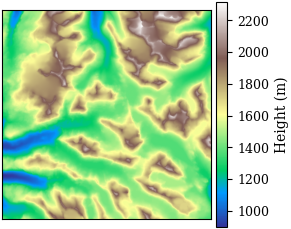

In [55]:
# Ensure ICML style is set and create figures directory
setup_icml_style()
os.makedirs('figures', exist_ok=True)

# =============================================================================
# Figure (a): Terrain Heatmap - Separate figure for LaTeX subfigure
# =============================================================================
fig_terrain, ax_terrain = plt.subplots(figsize=(ICML_COLUMN_WIDTH, ICML_COLUMN_WIDTH))

# Plot terrain heatmap
im = ax_terrain.imshow(terrain_full, cmap='terrain', aspect='equal')

# Remove axis ticks
ax_terrain.set_xticks([])
ax_terrain.set_yticks([])

# Add colorbar
cbar = plt.colorbar(im, ax=ax_terrain, shrink=0.9, pad=0.02)
cbar.set_label('Height (m)')

# Save terrain figure
fig_terrain.savefig('figures/icml_terrain_heatmap.pdf', dpi=300, bbox_inches='tight')
fig_terrain.savefig('figures/icml_terrain_heatmap.png', dpi=300, bbox_inches='tight')

print("Saved: figures/icml_terrain_heatmap.pdf")
print("Saved: figures/icml_terrain_heatmap.png")
plt.show()

Saved: figures/icml_transferability.pdf
Saved: figures/icml_transferability.png


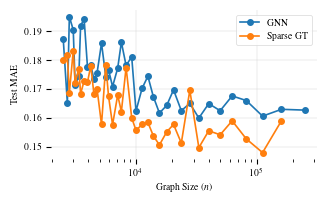

In [71]:
# =============================================================================
# Figure (b): Transferability Plot - Separate figure for LaTeX subfigure
# =============================================================================
# Re-apply ICML style in case it was reset
setup_icml_style()
plt.rcParams.update({
    "axes.labelsize": 7,  # Controls 'Graph Size (n)' & 'Test MAE'
    "xtick.labelsize": 7,  # Controls the numbers (10^4, 10^5)
    "ytick.labelsize": 7,   # Controls the numbers (0.16, 0.18)
    "legend.fontsize": 7,   # Controls the legend
})

fig_transfer, ax_transfer = plt.subplots(figsize=(ICML_WIDTH_SINGLE, 2.0))

# Label mapping for paper
LABEL_MAP = {'TAGConv': 'GNN', 'SparseGT': 'Sparse GT'}
COLOR_MAP = {'GNN': '#1f77b4', 'Sparse GT': '#ff7f0e'}

# Prepare data
df_plot = best_per_resolution.copy()
df_plot['Model'] = df_plot['layer_type'].map(LABEL_MAP)

# Plot each model
for model_name in ['GNN', 'Sparse GT']:
    model_data = df_plot[df_plot['Model'] == model_name].sort_values('num_nodes')
    ax_transfer.plot(model_data['num_nodes'], model_data[ERROR_COL], 
                     marker='o', label=model_name, color=COLOR_MAP[model_name],
                     linewidth=1.2, markersize=4)

# Log scale for x-axis
ax_transfer.set_xscale('log')

# Axis labels
ax_transfer.set_xlabel(r"Graph Size ($n$)")
ax_transfer.set_ylabel(ERROR_LABEL)

# Grid
ax_transfer.grid(True, color='lightgray', linestyle='-', linewidth=0.3)

# Remove spines for cleaner look
for spine in ax_transfer.spines.values():
    spine.set_visible(False)

# Legend
legend = ax_transfer.legend(loc='upper right', frameon=True, 
                            facecolor='white', framealpha=0.9, edgecolor='lightgray')
legend.get_frame().set_linewidth(0.5)

# Save transferability figure
fig_transfer.savefig('figures/icml_transferability.pdf', bbox_inches='tight', pad_inches=0.02)
fig_transfer.savefig('figures/icml_transferability.png', dpi=300, bbox_inches='tight', pad_inches=0.02)

print("Saved: figures/icml_transferability.pdf")
print("Saved: figures/icml_transferability.png")
plt.show()